In [77]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import rcParams
plt.style.use('ggplot')

# for recommendation systems
from surprise import SVD,BaselineOnly, NormalPredictor, evaluate
from surprise.model_selection import cross_validate, GridSearchCV, RandomizedSearchCV
from surprise import Reader, Dataset
from surprise import accuracy
from surprise.model_selection import KFold

### Loading data

In [24]:
# First time data load.
movies = pd.read_csv('../MovieLens/ml-latest-small/movies.csv')
ratings = pd.read_csv('../MovieLens/ml-latest-small/ratings.csv')
tags = pd.read_csv('../MovieLens/ml-latest-small/tags.csv')

In [25]:
movies.head(10)

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy
5,6,Heat (1995),Action|Crime|Thriller
6,7,Sabrina (1995),Comedy|Romance
7,8,Tom and Huck (1995),Adventure|Children
8,9,Sudden Death (1995),Action
9,10,GoldenEye (1995),Action|Adventure|Thriller


### Get years and genres
#### Years distribution

In [26]:
# Split title and release year in separate columns in movies dataframe. Convert year to timestamp.
movies['year'] = movies.title.str.extract("\((\d{4})\)", expand=True)

In [27]:
# look at missed values
movies.isna().sum(axis = 0)

movieId     0
title       0
genres      0
year       13
dtype: int64

In [28]:
# drop nan
movies.dropna(inplace=True)

In [29]:
# change format of year column
movies.year = movies.year.astype(int)
#movies.year = pd.to_datetime(movies.year, format='%Y')

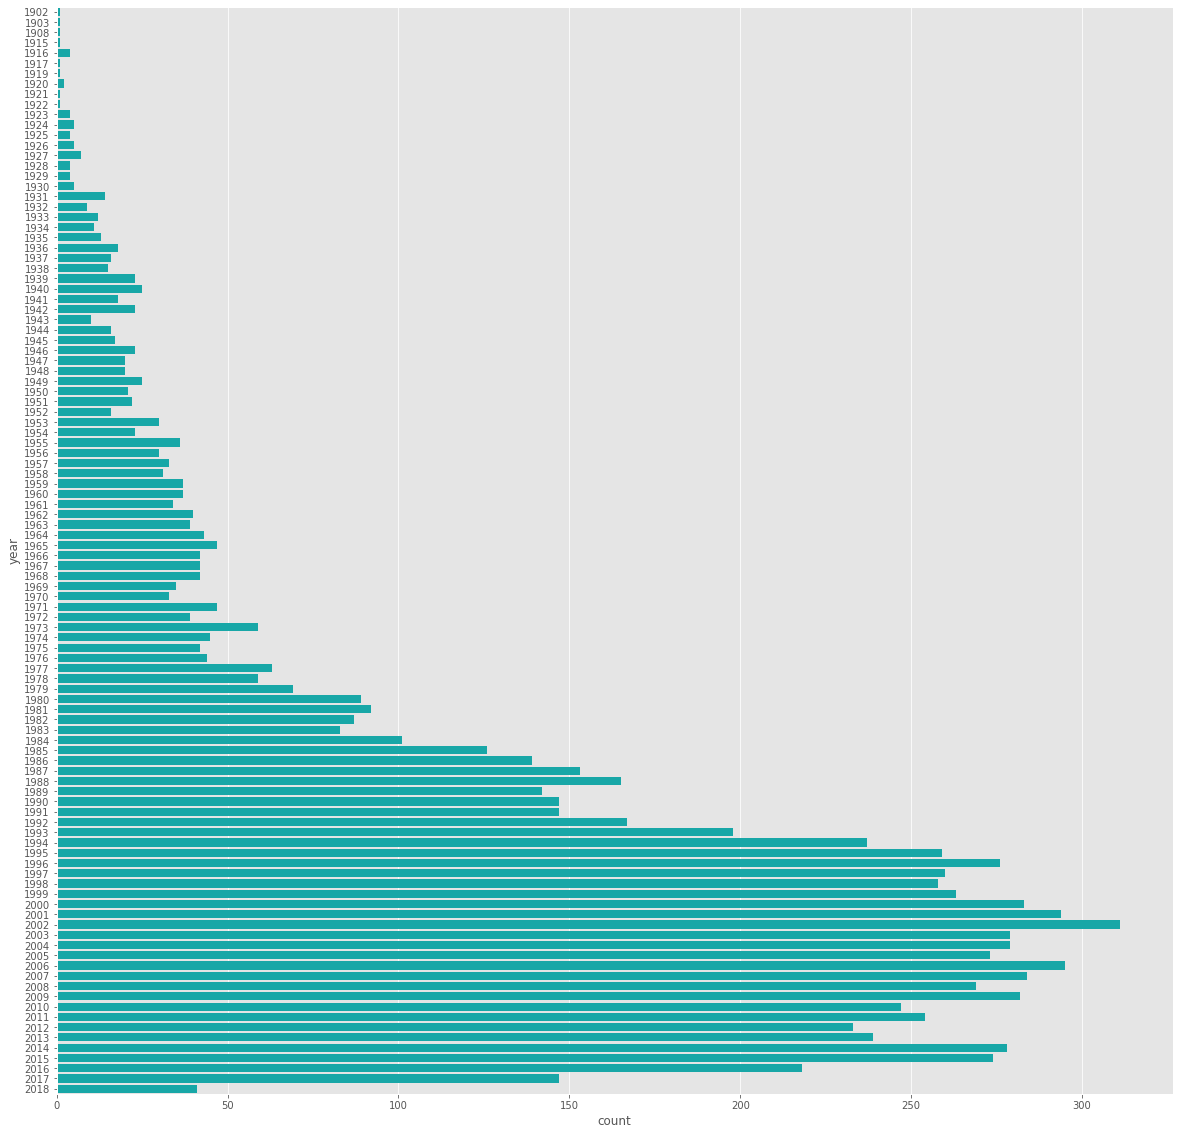

In [30]:
f, ax = plt.subplots(figsize=(20, 20))
sns.countplot(y="year", data=movies, color="c");

#### Genres

In [31]:
# Categorize movies genres properly.
movies = movies.join(movies.genres.str.get_dummies().astype(bool))
movies.drop('genres', inplace=True, axis=1)

In [32]:
movies.head(2)

,movieId,title,year,(no genres listed),Action,Adventure,Animation,Children,Comedy,Crime,...,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story (1995),1995,False,False,True,True,True,True,False,...,False,False,False,False,False,False,False,False,False,False
1,2,Jumanji (1995),1995,False,False,True,False,True,False,False,...,False,False,False,False,False,False,False,False,False,False


In [33]:
distribution_genres = movies.iloc[:,3:].sum(axis=0)

In [34]:
distribution_genres.index

Index(['(no genres listed)', 'Action', 'Adventure', 'Animation', 'Children',
       'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir',
       'Horror', 'IMAX', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller',
       'War', 'Western'],
      dtype='object')

Text(0.5, 1.0, 'Genres distribution')

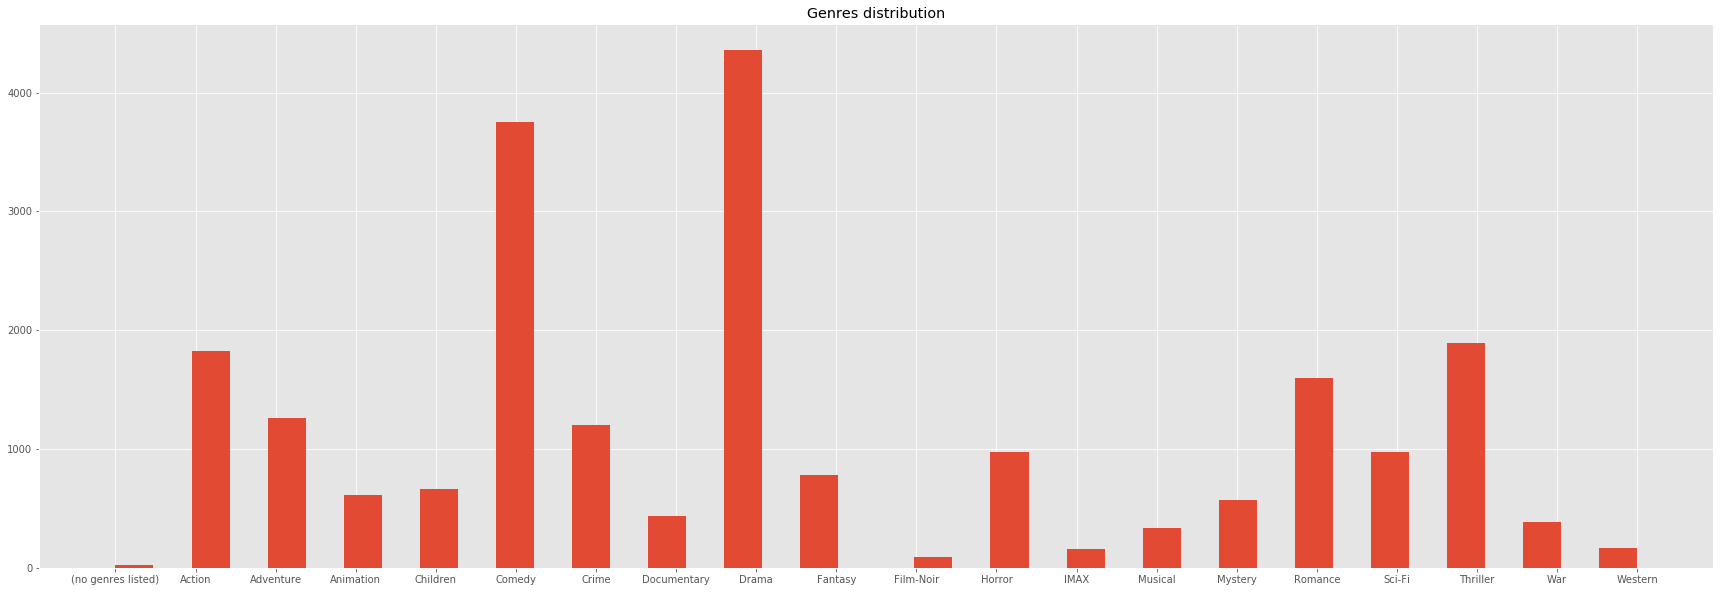

In [35]:
plt.figure(figsize=(30,10))
plt.hist(distribution_genres.index , weights=distribution_genres.values, bins=40)
plt.title("Genres distribution")

#### Ratings

**Average number of rated films**: 165.30491803278687
**Median number of rated films**: 70.5


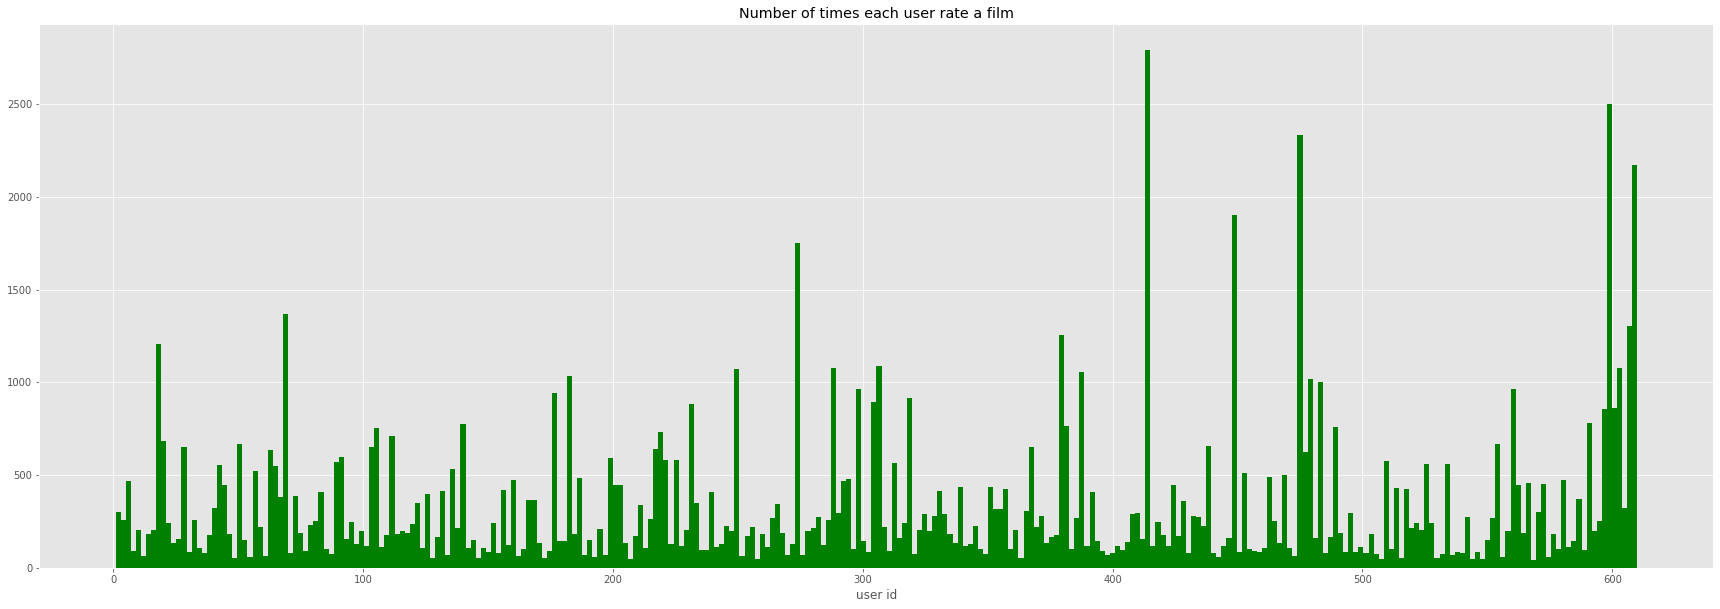

In [36]:
# amount of ratings each person gave
user_rating = ratings.groupby(['userId'])['rating'].count()

plt.figure(figsize=(30,10))
plt.hist(user_rating.index , weights=user_rating.values, bins=300, color = 'green')
plt.title("Number of times each user rate a film")
plt.xlabel('user id');
print("**Average number of rated films**:", ratings.groupby(['userId'])['rating'].count().mean())
print("**Median number of rated films**:", ratings.groupby(['userId'])['rating'].count().median())

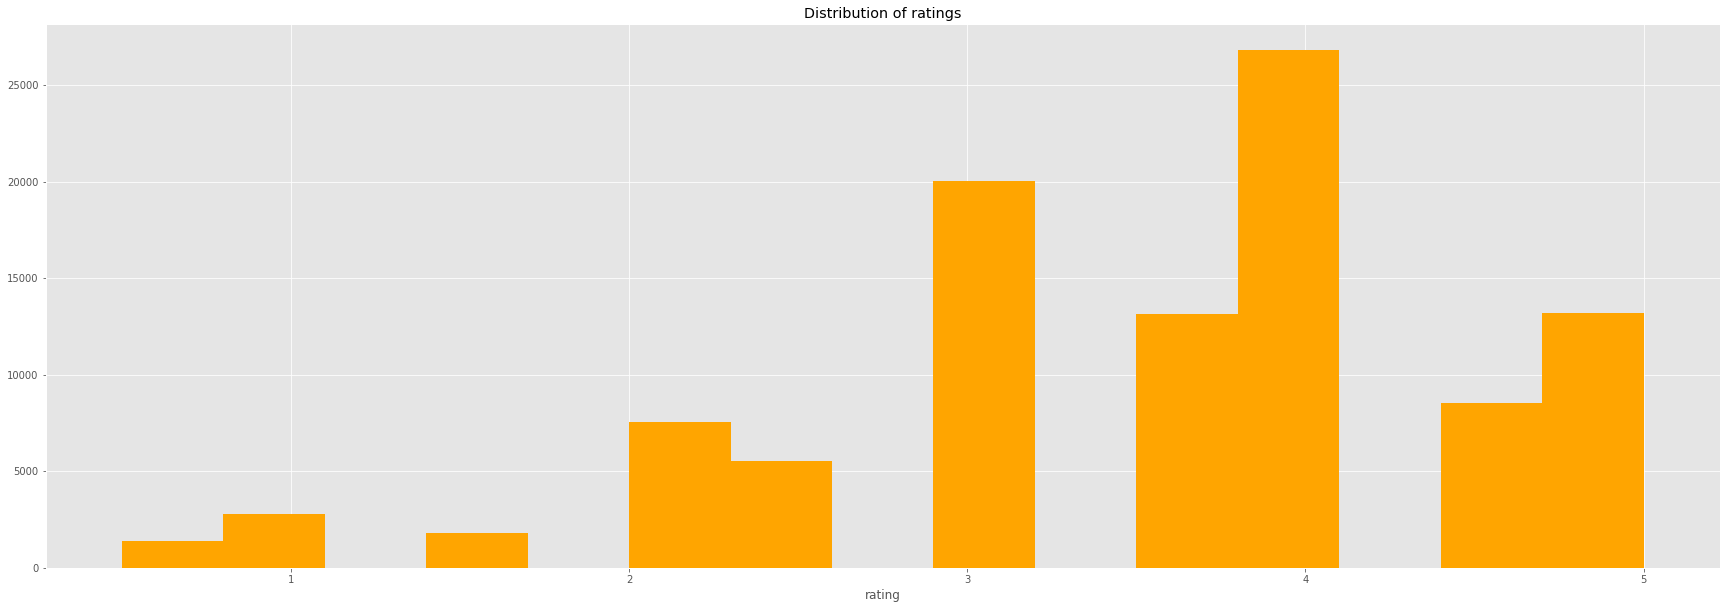

In [37]:
# Distribution of ratings
plt.figure(figsize=(30,10))
plt.hist(list(dict(ratings.rating.value_counts()).keys())  , 
         weights=list(dict(ratings.rating.value_counts()).values()), 
         bins=15, 
         color = 'orange')
plt.title("Distribution of ratings")
plt.xlabel('rating');


In [69]:
ratings.head(2)

,userId,movieId,rating
0,1,1,4.0
1,1,3,4.0


## Work with Surprize Library

In [45]:
ratings = ratings.drop('timestamp', axis=1)

In [47]:
# Since we are going to use 'surprise' library, we need to do some preprocessing for dataset

#reader = Reader(line_format='userId movieId rating')
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(ratings[['userId', 'movieId', 'rating']], reader)

#### SVD

In [79]:
param_grid = {'n_epochs': [20,30,40], 'lr_all': [0.001, 0.005, 0.008],
              'reg_all': [0.03, 0.02, 0.01]}
gs = RandomizedSearchCV(SVD, param_grid, measures=['rmse'], cv=3)

gs.fit(data)

# best RMSE score
print(gs.best_score['rmse'])

# combination of parameters that gave the best RMSE score
print(gs.best_params['rmse'])

0.877493987887314
{'n_epochs': 40, 'lr_all': 0.005, 'reg_all': 0.03}


In [80]:
# define a cross-validation iterator
kf = KFold(n_splits=3)
algo = SVD(n_epochs = 40, lr_all = 0.005, reg_all=0.03)

for trainset, testset in kf.split(data):

    # train and test algorithm.
    algo.fit(trainset)
    predictions = algo.test(testset)

    # Compute and print Root Mean Squared Error
    accuracy.rmse(predictions, verbose=True)

RMSE: 0.8755
RMSE: 0.8810
RMSE: 0.8765


In [74]:
#BaseLine
algo = NormalPredictor()
for trainset, testset in kf.split(data):

    # train and test algorithm.
    algo.fit(trainset)
    predictions = algo.test(testset)

    # Compute and print Root Mean Squared Error
    accuracy.rmse(predictions, verbose=True)

RMSE: 1.4230
RMSE: 1.4223
RMSE: 1.4263


In [82]:
df_predictions = pd.DataFrame(predictions, columns=['uid', 'iid', 'rui', 'est', 'details'])  

In [83]:
df_predictions

,uid,iid,rui,est,details
0,356,6636,3.5,3.874443,{'was_impossible': False}
1,89,11,2.5,3.948008,{'was_impossible': False}
2,495,35836,5.0,4.233444,{'was_impossible': False}
3,522,1221,4.0,4.067104,{'was_impossible': False}
4,249,45431,3.5,3.797308,{'was_impossible': False}
5,298,6006,0.5,2.398358,{'was_impossible': False}
6,555,1033,4.0,3.701275,{'was_impossible': False}
7,10,8529,3.5,3.345912,{'was_impossible': False}
8,448,6595,1.5,2.947235,{'was_impossible': False}
9,603,1663,3.0,3.902779,{'was_impossible': False}
